# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from tensorflow.keras import backend as K
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ConvNeXtBase
seed = 42
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
import sys
sys.path.append('/kaggle/input/augment/')
from AugmentationHelper import apply_geometric_transform, apply_intensity_transform, apply_total_transform, plot_images_and_masks

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## ⏳ Load the Data

In [3]:
file_path = "/kaggle/input/mars-data/mars_for_students.npz"

data = np.load(file_path)

training_set = data["training_set"]
images = training_set[:, 0]
labels = training_set[:, 1]

print(f"Training X shape: {images.shape}")
print(f"Training y shape: {labels.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)


In [4]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
# 10% of input data to both test and validation sets
test_ratio = 0.05 
validation_ratio = 0.05 / 0.9 

train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    images, labels, test_size=test_ratio, random_state=seed
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=validation_ratio, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(train_img)}")
print(f"Validation: {len(val_img)}")
print(f"Test: {len(test_img)}")

Splitting data...
Data splitted!

Number of images:
Train: 2346
Validation: 138
Test: 131


In [5]:
# Set number of classes
NUM_CLASSES = 5

# Set batch size for training
BATCH_SIZE = 4

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 200

## Preprocessing

In [6]:
train_img = train_img.astype(np.uint8)
train_lbl = train_lbl.astype(np.uint8)

train_img_i, train_lbl_i = apply_intensity_transform(train_img, train_lbl)
train_img_g, train_lbl_g = apply_geometric_transform(train_img, train_lbl)
train_img_t, train_lbl_t = apply_total_transform(train_img, train_lbl)

train_img = np.concatenate((train_img, train_img_i, train_img_g, train_img_t), axis=0)
train_lbl = np.concatenate((train_lbl, train_lbl_i, train_lbl_g, train_lbl_t), axis=0)

In [7]:
def load_single_image(image, label, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    image = tf.cast(image, tf.float32)
    image = image[..., np.newaxis] / 255.0
    image = tf.image.grayscale_to_rgb(image)

    # Read and preprocess the label
    label = tf.cast(label, tf.int32)
    label = label[..., np.newaxis]
    return image, label

In [8]:
labels_map =  {
    0: 'Background',
    1: 'Soil',
    2: 'Bedrock',
    3: 'Sand',
    4: 'Big Roc'
}
category_map = {0:0, 1:1, 2:2, 3:3, 4:4}
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)#@tf.function


def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [9]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y),
            num_parallel_calls=tf.data.AUTOTUNE
        ) 
        
    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [10]:
# Create the datasets
print("Creating datasets...")

train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 3)
Images shape: (4, 64, 128, 3)
Labels shape: (4, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


Visualizing examples from the training set:


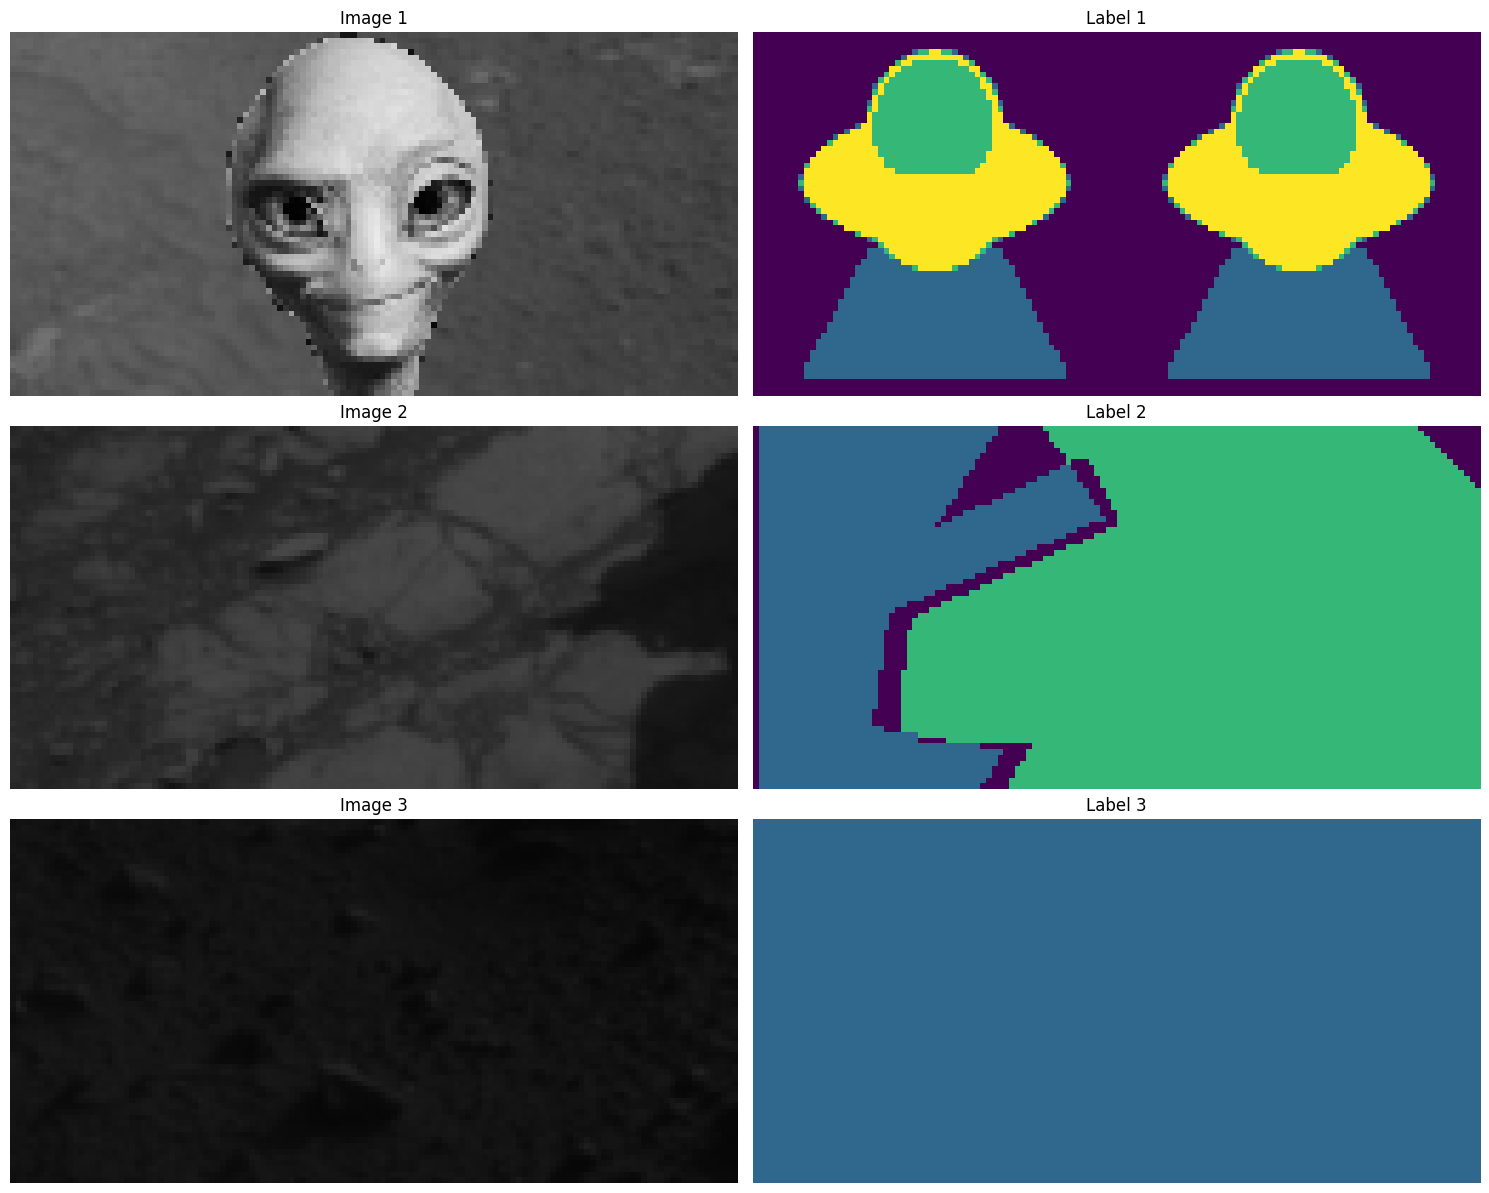

In [11]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=3)

## Build the Model

In [12]:
'''
References: 
Paper: https://arxiv.org/pdf/1707.03718
Code: https://github.com/nickhitsai/LinkNet-Keras/blob/master/linknet.py
'''
def link_net(input_shape=input_shape):

    # Input Layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')
    # Input Block
    x = tfkl.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2))(inputs)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)
    x = tfkl.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    skipped = []

    # Parameters m and n from the paper
    parameters_encoder = [[64, 64], [64, 128], [128, 256], [256, 512]]
    parameters_decoder = [[64, 64], [128, 64], [256, 128], [512, 256]]
    depth = 4
    # Encoding
    for i in range(depth):
        # Encoder Block
        # Conv1
        skip1 = x
        x = tfkl.Conv2D(filters=parameters_encoder[i][1],
                        kernel_size=(3,3),
                        strides=(2, 2),
                        padding='same',
                        name="conv1-encoder"+str(i+1))(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)
        # Conv2
        x = tfkl.Conv2D(filters=parameters_encoder[i][1],
                        kernel_size=(3,3),
                        padding='same',
                        name="conv2-encoder"+str(i+1))(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)

        # Connect-sum: The dimensions are not the same, so we have to equalize them ####################
        input_shape = skip1.shape
        residual_shape = x.shape
        stride_width = int(round(input_shape[1] / residual_shape[1]))
        stride_height = int(round(input_shape[2] / residual_shape[2]))

        new_skip = tfkl.Conv2D(filters=residual_shape[3],
                      kernel_size=(1, 1),
                      strides=(stride_width, stride_height),
                      padding="valid",
                      kernel_initializer="he_normal",
                      kernel_regularizer=l2(0.0001))(skip1)
        skip2 = keras.layers.add([new_skip, x])
        ################################################################################################ 
        
        # Conv3
        x = tfkl.Conv2D(filters=parameters_encoder[i][1],
                        kernel_size=(3,3),
                        padding='same',
                        name="conv3-encoder"+str(i+1))(skip2)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)
        # Conv4
        x = tfkl.Conv2D(filters=parameters_encoder[i][1],
                        kernel_size=(3,3),
                        padding='same',
                        name="conv4-encoder"+str(i+1))(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)

        # Connect-sum
        # Connect-sum: The dimensions are not the same, so we have to equalize them ####################
        input_shape = skip2.shape
        residual_shape = x.shape
        stride_width = int(round(input_shape[1] / residual_shape[1]))
        stride_height = int(round(input_shape[2] / residual_shape[2]))

        new_skip = tfkl.Conv2D(filters=residual_shape[3],
                      kernel_size=(1, 1),
                      strides=(stride_width, stride_height),
                      padding="valid",
                      kernel_initializer="he_normal",
                      kernel_regularizer=l2(0.0001))(skip2)
        x = keras.layers.add([new_skip, x])
        ################################################################################################ 

        # Save the layer for skip connections
        skipped.append(x)

    # Decoding
    for i in range(depth):
        # Decoder Block
        # Conv1
        x = tfkl.Conv2D(filters=int(parameters_decoder[depth - i - 1][0]/4), #m
                        kernel_size=(1,1),
                        name="conv1-downsampling"+str(i+1))(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)

        # Full Conv2
        x = tfkl.UpSampling2D((2,2))(x)
        x = tfkl.Conv2D(filters=int(parameters_decoder[depth - i - 1][0]/4), #m
                        kernel_size=(3,3),
                        padding='same',
                        name="conv2-downsampling"+str(i+1))(x)
        x = tfkl.BatchNormalization()(x) 
        x = tfkl.ReLU()(x)

        # Conv3
        x = tfkl.Conv2D(filters=parameters_decoder[depth - i - 1][1], #n
                        kernel_size=(1,1),
                        name="conv3-downsampling"+str(i+1))(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)

        # Prepare Skip Connections for the NEXT BLOCK
        if i != depth-1: #if its the last block, no skip connections
            x = keras.layers.add([x, skipped[depth - i - 2]])
            x = tfkl.ReLU()(x)

    # Output Layers
    # Full Conv1
    x = tfkl.UpSampling2D((2,2))(x)
    x = tfkl.Conv2D(filters=32,
                    kernel_size=(3,3),
                    strides=(1, 1),
                    padding='same',
                    name="output-fullconv1")(x)
    x = tfkl.BatchNormalization()(x) 
    x = tfkl.ReLU()(x)

    # Conv2
    x = tfkl.Conv2D(filters=32,
                    kernel_size=(3,3),
                    strides=(1, 1),
                    padding='same',
                    name="output-conv2")(x)
    x = tfkl.BatchNormalization()(x) 
    x = tfkl.ReLU()(x)

    # Full Conv3
    x = tfkl.UpSampling2D((2,2))(x)
    x = tfkl.Conv2D(filters=NUM_CLASSES,
                    kernel_size=(2,2),
                    strides=(1, 1),
                    padding='same',
                    name="output-fullconv3")(x)
    x = tfkl.BatchNormalization()(x) 
    outputs = tfkl.ReLU()(x)
    
    model = tf.keras.Model(inputs, outputs, name='LinkNet')

    return model

In [13]:
def u_net(input_shape=input_shape, depth=4, 
          d_conv_count = 3, b_conv_count = 3, u_conv_count = 3, 
          start_filter=32, skip_connections=True, dropout=0.2):

    # Input Layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    x = inputs
    skipped = []
    # Downsampling
    for i in range(depth):
        for j in range(d_conv_count):
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            strides=(1, 1),
                            padding='same')(x)
            x = tfkl.BatchNormalization()(x) 
            x = tfkl.ReLU()(x)

        if skip_connections:
            # Save the layer for skip connections
            skipped.append(x)

        x = tfkl.MaxPooling2D(pool_size=(2,2))(x)
        x = tfkl.Dropout(dropout)(x)
        
        start_filter = start_filter * 2
    
    # Bottleneck
    for j in range(b_conv_count):
        x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            strides=(1, 1),
                            padding='same')(x)
        x = tfkl.BatchNormalization()(x) 
        x = tfkl.ReLU()(x)
    
    start_filter = start_filter // 2

    # Upsampling
    for i in range(depth):
        x = tfkl.UpSampling2D(2, interpolation='bilinear')(x)

        if skip_connections:
            x = tfkl.Concatenate()([x, skipped[depth - i - 1]])

        x = tfkl.Dropout(dropout)(x)

        for j in range(u_conv_count):
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            strides=(1, 1),
                            padding='same')(x)
            x = tfkl.BatchNormalization()(x) ## remove?
            x = tfkl.ReLU()(x)
        start_filter = start_filter // 2
    

    # Output Layer
    outputs = tfkl.Conv2D(filters=NUM_CLASSES,
                        kernel_size=(1,1),
                        strides=(1, 1),
                        padding='same',
                        activation='softmax',
                        name="output_layer")(x)
    
    model = tf.keras.Model(inputs, outputs, name='UNet')
    return model

In [14]:
'''
References:
Paper: https://qims.amegroups.org/article/view/43519/html
Code: https://github.com/THUHoloLab/Dense-U-net/blob/master/Dense-U-net/Dense_U_net.py
'''

def dense_unet(input_shape=input_shape, depth=4, 
               d_conv_count = 3, u_conv_count = 3,
               start_filter=32, dropout=0.2):

    # Input Layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    next = inputs
    skipped = []

    # Downsampling
    for i in range(depth):
        # Now this is a Dense Block
        for j in range(d_conv_count):
            
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            kernel_initializer="he_normal",
                            strides=(1, 1),
                            padding='same')(next)
            x = tfkl.BatchNormalization()(x) 
            conv_block = tfkl.ReLU()(x)
            next = tfkl.Concatenate()([conv_block, next]) 

        
        skipped.append(conv_block)

        x = tfkl.MaxPooling2D(pool_size=(2,2))(conv_block)
        next = tfkl.Dropout(dropout)(x)
        
        start_filter = start_filter * 2
    
    # Bottleneck
    x = tfkl.Conv2D(filters=start_filter,
                        kernel_size=(3,3),
                        strides=(1, 1),
                        kernel_initializer="he_normal",
                        padding='same')(next)
    x = tfkl.BatchNormalization()(x) ##### not sure
    x = tfkl.ReLU()(x)
    next = tfkl.Dropout(dropout)(x)
    
    start_filter = start_filter // 2

    # Upsampling
    for i in range(depth):
        x = tfkl.UpSampling2D(2, interpolation='bilinear')(next)
        x = tfkl.Concatenate()([x, skipped.pop()]) ## try without axis
        next = tfkl.Dropout(dropout)(x)

        # Dense Block again
        for j in range(u_conv_count):
            
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            kernel_initializer="he_normal",
                            strides=(1, 1),
                            padding='same')(next)            
            x = tfkl.BatchNormalization()(x) 
            conv_block = tfkl.ReLU()(x)
            next = tfkl.Concatenate()([conv_block, next]) 
            
        start_filter = start_filter // 2
    
    # Output Layer
    outputs = tfkl.Conv2D(filters=NUM_CLASSES,
                        kernel_size=(1,1),
                        strides=(1, 1),
                        padding='same',
                        activation='sigmoid',
                        name="output_layer")(next)
    
    model = tf.keras.Model(inputs, outputs, name='Dense_UNet')
    return model
    

In [15]:
model = u_net()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 64, 128, │       896 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d[0][0]   │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu (ReLU)      │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 64, 128, │     9,248 │ re_lu[0][0]    │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_1[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_1 (ReLU)    │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_2 (Conv2D) │ (None, 64, 128, │     9,248 │ re_lu_1[0][0]  │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_2[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_2 (ReLU)    │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ re_lu_2[0][0]  │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout (Dropout) │ (None, 32, 64,  │         0 │ max_pooling2d… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_3 (Conv2D) │ (None, 32, 64,  │    18,496 │ dropout[0][0]  │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_3[0][0] │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_3 (ReLU)    │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_4 (Conv2D) │ (None, 32, 64,  │    36,928 │ re_lu_3[0][0]  │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_4[0][0] │   Y 

 Total params: 11,791,941 (44.98 MB)

 Trainable params: 11,783,109 (44.95 MB)

 Non-trainable params: 8,832 (34.50 KB)

### Metrics

In [16]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [17]:
# https://stackoverflow.com/questions/65125670/implementing-multiclass-dice-loss-function
def dice_loss(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for X categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=NUM_CLASSES)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_loss_multiclass(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_loss(y_true, y_pred)

def combined_multiclass_loss(y_true, y_pred, alpha=0.5, beta=0.5):
    dice = dice_loss_multiclass(y_true, y_pred)
    categorical_ce = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    return alpha * dice + beta * categorical_ce

# TODO
# boundary loss



In [18]:
# Compile the model
print("Compiling model...")
model.compile(
    loss= dice_loss_multiclass, #combined_multiclass_loss,#keras.losses.CategoricalFocalCrossentropy(), #dice_loss_multiclass, #tf.keras.losses.Dice, #tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


## 🛠️ Train the Model

In [19]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    mode="auto",
    min_lr=1e-5
)

In [20]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Epoch 1/200


I0000 00:00:1733441607.398091      65 service.cc:145] XLA service 0x7b02b0002360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733441607.398156      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   5/2346 ━━━━━━━━━━━━━━━━━━━━ 1:05 28ms/step - accuracy: 0.2752 - loss: 0.7839 - mean_iou: 0.0858

I0000 00:00:1733441631.265997      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2346/2346 ━━━━━━━━━━━━━━━━━━━━ 101s 26ms/step - accuracy: 0.3304 - loss: 0.6360 - mean_iou: 0.1342 - val_accuracy: 0.3811 - val_loss: 0.5681 - val_mean_iou: 0.1628 - learning_rate: 0.0010
Epoch 2/200
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 58s 25ms/step - accuracy: 0.3456 - loss: 0.6110 - mean_iou: 0.1430 - val_accuracy: 0.3820 - val_loss: 0.5665 - val_mean_iou: 0.1562 - learning_rate: 0.0010
Epoch 3/200
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 58s 25ms/step - accuracy: 0.3480 - loss: 0.6066 - mean_iou: 0.1531 - val_accuracy: 0.3564 - val_loss: 0.5947 - val_mean_iou: 0.1224 - learning_rate: 0.0010
Epoch 4/200
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 58s 25ms/step - accuracy: 0.3670 - loss: 0.5854 - mean_iou: 0.1792 - val_accuracy: 0.4091 - val_loss: 0.5369 - val_mean_iou: 0.1987 - learning_rate: 0.0010
Epoch 5/200
2346/2346 ━━━━━━━━━━━━━━━━━━━━ 57s 24ms/step - accuracy: 0.3918 - loss: 0.5573 - mean_iou: 0.2076 - val_accuracy: 0.3619 - val_loss: 0.5882 - val_mean_iou: 0.1283 - learning_rate: 0.0010
Epoch 6/200
2346

In [21]:
# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

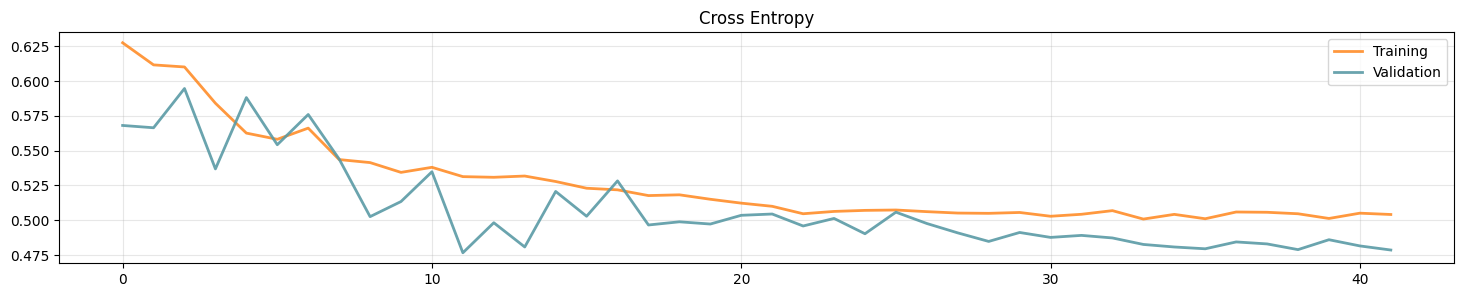

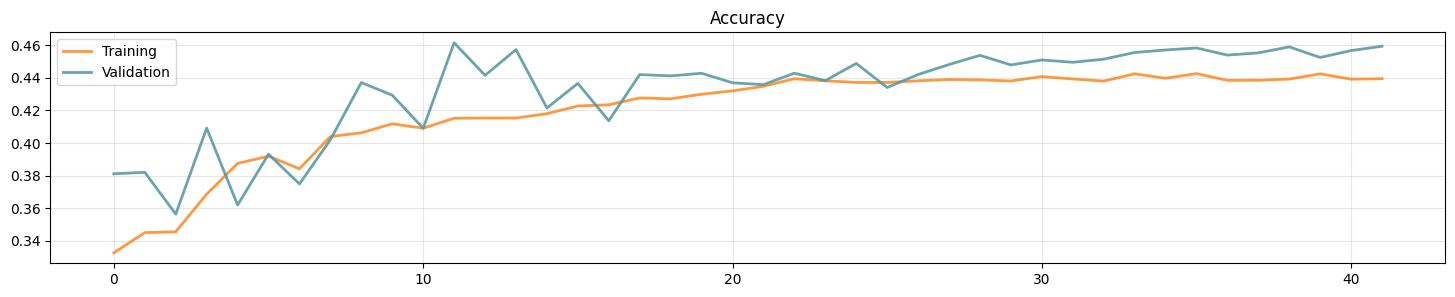

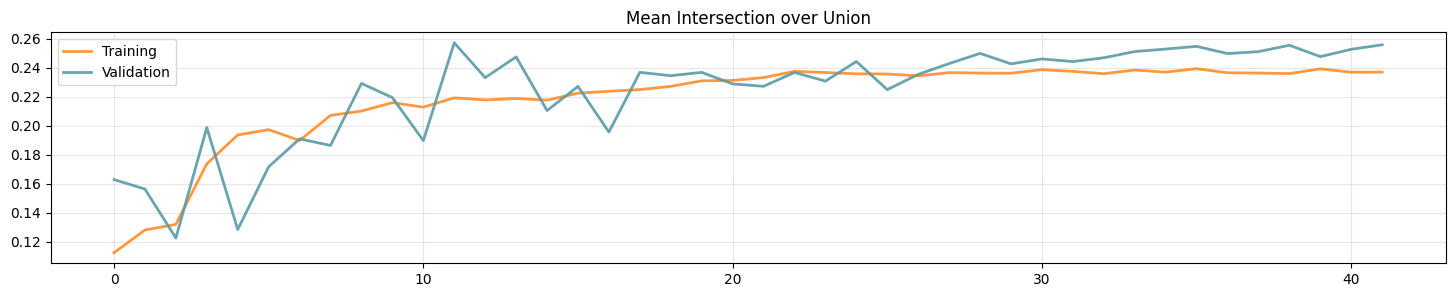

In [22]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [23]:
X_test_submission = data["test_set"]
print(f"Test X shape: {X_test_submission.shape}")
X_test_submission = X_test_submission[..., np.newaxis] / 255.0
X_test_submission = tf.cast(X_test_submission, tf.float32)
X_test_submission = tf.image.grayscale_to_rgb(X_test_submission)


Test X shape: (10022, 64, 128)


In [24]:
# Load UNet model without compiling
model = tfk.models.load_model('/kaggle/working/model.keras', compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 64, 128, │       896 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d[0][0]   │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu (ReLU)      │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 64, 128, │     9,248 │ re_lu[0][0]    │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_1[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_1 (ReLU)    │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_2 (Conv2D) │ (None, 64, 128, │     9,248 │ re_lu_1[0][0]  │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_2[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_2 (ReLU)    │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ re_lu_2[0][0]  │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout (Dropout) │ (None, 32, 64,  │         0 │ max_pooling2d… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_3 (Conv2D) │ (None, 32, 64,  │    18,496 │ dropout[0][0]  │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_3[0][0] │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_3 (ReLU)    │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_4 (Conv2D) │ (None, 32, 64,  │    36,928 │ re_lu_3[0][0]  │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_4[0][0] │   Y 

 Total params: 11,791,941 (44.98 MB)

 Trainable params: 11,783,109 (44.95 MB)

 Non-trainable params: 8,832 (34.50 KB)

In [25]:
preds = model.predict(X_test_submission)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step
Predictions shape: (10022, 64, 128)


In [26]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

# Create and download the csv submission file
submission_filename = f"submission.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)